# Iris eye Recognition

Localization


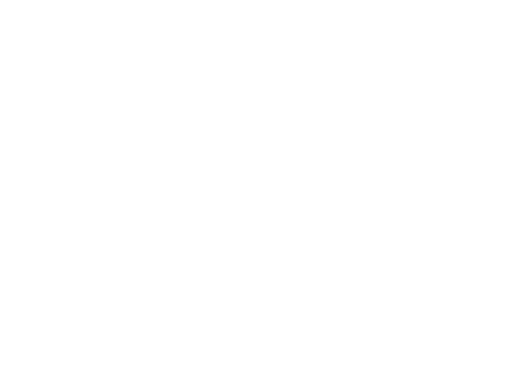

In [1]:
## For whole iris detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('preprocessing/S6000S00.jpg', cv2.IMREAD_COLOR)

# Convert the image to grayscale (important for circle detection)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise (helps with circle detection)
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 2)

# Use HoughCircles to detect circles
circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=30,
    param1=60,
    param2=30,
    minRadius=40,
    maxRadius=100
)

# Check if any circles were found
if circles is not None:
    # Convert the circle coordinates to integer values
    circles = np.uint16(np.around(circles))
    x = circles[0][0][0]
    y = circles[0][0][1]
    r = circles[0][0][2]

    zoom_out_factor = 1
    crop_size = int(r * zoom_out_factor * 2)
    x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
    x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])
    cropped_image = image[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, (224, 224))
    cv2.imwrite('preprocessing/S6000S00cropped&resized.jpg', resized_image)

    # Loop through the detected circles
    for circle in circles[0, :]:
        # Draw the outer circle (in green)
        center = (circle[0], circle[1])  # (x, y) coordinates of the circle center
        radius = circle[2]               # radius of the circle
        cv2.circle(image, center, radius, (0, 255, 0), 2)  # Draw the circle

        # Draw the center of the circle (in red)
        cv2.circle(image, center, 2, (0, 0, 255), 3)  # Draw the center point


# Convert the image back to RGB for displaying
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result
#plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Normalization

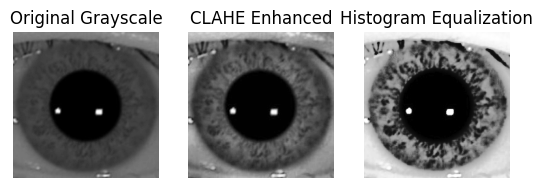

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('preprocessing/S6000S00cropped&resized.jpg', cv2.IMREAD_COLOR)

def execute(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)

    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Original Grayscale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(clahe_image, cmap='gray')
    plt.title("CLAHE Enhanced")
    plt.axis('off')


    equalized_image = cv2.equalizeHist(gray)
    equalized_image_normalized = equalized_image / 255.0

    plt.subplot(1, 3, 3)
    plt.imshow(equalized_image_normalized, cmap='gray')
    plt.title("Histogram Equalization")
    plt.axis('off')

    plt.show()


execute(image)